In [39]:
#This is very similar to my classification from week 4, but has been extended to include the standard deviation
#for the results, as well as the overall acccuracy. It also includes results for the training set as well. 

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

ice_mask = pd.read_csv('../data/ice_mask.csv')

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def replace_with_abs(df, columns):
    new_df = df.copy()
    for column in columns:
        new_df[column] = new_df[column].abs()
    return new_df

In [40]:
def doRandomForest(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = RandomForestClassifier(random_state=randomState)
        model.fit(X_train, y_train)
        
        importances.append(model.feature_importances_)

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
    
    print("\nAverage Feature Importances:", average_importances)
    print("Std of Feature Importances:", std_importances)
    return average_importances, std_importances


In [41]:
#++++++++++++++++++++++++++++++++++++++++++RANDOM FOREST CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(ice_mask)


rf_importances, std_importances = doRandomForest(scaled_df, seed, 30)


Average Training Accuracy: 1.000, Std: 0.000
Training Category Metrics:
  grounded_ice: Avg: 1.000, Std: 0.000
  floating_ice: Avg: 1.000, Std: 0.000
  open_ocean: Avg: 1.000, Std: 0.000

Average Test Accuracy: 0.963, Std: 0.005
Test Category Metrics:
  grounded_ice: Avg: 0.974, Std: 0.010
  floating_ice: Avg: 0.464, Std: 0.088
  open_ocean: Avg: 0.990, Std: 0.003

Average Feature Importances: [0.04714329 0.04570688 0.24677296 0.55838563 0.10199124]
Std of Feature Importances: [0.00483401 0.00597338 0.02130048 0.02567824 0.00897103]


In [42]:
#++++++++++++++++++++++++++++++++++++++++++RANDOM FOREST CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++
seed = 101
abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)

abs_rf_importances, abs_std_importances = doRandomForest(abs_scaled_df, seed, 30)


Average Training Accuracy: 1.000, Std: 0.000
Training Category Metrics:
  grounded_ice: Avg: 1.000, Std: 0.000
  floating_ice: Avg: 1.000, Std: 0.000
  open_ocean: Avg: 1.000, Std: 0.000

Average Test Accuracy: 0.965, Std: 0.006
Test Category Metrics:
  grounded_ice: Avg: 0.977, Std: 0.008
  floating_ice: Avg: 0.489, Std: 0.081
  open_ocean: Avg: 0.991, Std: 0.004

Average Feature Importances: [0.03749123 0.06972665 0.24384083 0.55303175 0.09590953]
Std of Feature Importances: [0.00395818 0.00902233 0.01981285 0.0244365  0.00952122]


In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doSVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    coefficients = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='linear', random_state=randomState)
        model.fit(X_train, y_train)
        
        coefficients.append(model.coef_[0])

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_coefficients = np.mean(coefficients, axis=0)
    std_coefficients = np.std(coefficients, axis=0)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
    print("\nAverage Coefficients:", average_coefficients)
    print("Std of Coefficients:", std_coefficients)
    return average_coefficients, std_coefficients


In [44]:
#++++++++++++++++++++++++++++++++++++++++++++++SVM CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(ice_mask)

svm_coefficients, std_coefficients = doSVC(scaled_df, seed, 30)

Average Training Accuracy: 0.950, Std: 0.003
Training Category Metrics:
  grounded_ice: Avg: 0.976, Std: 0.004
  floating_ice: Avg: 0.000, Std: 0.000
  open_ocean: Avg: 0.995, Std: 0.001

Average Test Accuracy: 0.950, Std: 0.006
Test Category Metrics:
  grounded_ice: Avg: 0.978, Std: 0.009
  floating_ice: Avg: 0.000, Std: 0.000
  open_ocean: Avg: 0.994, Std: 0.002

Average Coefficients: [-0.02436612  0.01066642 -0.08166527  0.10287005  0.01437589]
Std of Coefficients: [0.04247008 0.02810276 0.03595347 0.04537286 0.04170781]


In [45]:
#+++++++++++++++++++++++++++++++++++++++++++SVM CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++++
seed = 101
abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)

abs_svm_coefficients, abs_std_coefficients = doSVC(abs_scaled_df, seed, 30)

Average Training Accuracy: 0.952, Std: 0.003
Training Category Metrics:
  grounded_ice: Avg: 0.982, Std: 0.004
  floating_ice: Avg: 0.000, Std: 0.000
  open_ocean: Avg: 0.996, Std: 0.001

Average Test Accuracy: 0.952, Std: 0.006
Test Category Metrics:
  grounded_ice: Avg: 0.983, Std: 0.008
  floating_ice: Avg: 0.000, Std: 0.000
  open_ocean: Avg: 0.995, Std: 0.002

Average Coefficients: [ 0.04301767  0.01972763 -0.10243462  0.09507223  0.01862005]
Std of Coefficients: [0.0262481  0.02785663 0.04698226 0.04332436 0.01735662]


In [46]:
def doMLP(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    perm_importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = MLPClassifier(max_iter=1000, random_state=randomState)
        model.fit(X_train, y_train)
        
        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

        # Calculate permutation feature importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=randomState)
        perm_importances.append(perm_importance.importances_mean)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_perm_importances = np.mean(perm_importances, axis=0)
    std_perm_importances = np.std(perm_importances, axis=0)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
    print("\nAverage Permutation Importances:", average_perm_importances)
    print("Std of Permutation Importances:", std_perm_importances)
    return average_perm_importances, std_perm_importances


In [47]:
#++++++++++++++++++++++++++++++++++++++++++++++MLP CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(ice_mask)

mlp_perms, std_perms = doMLP(scaled_df, seed, 30)

Average Training Accuracy: 0.953, Std: 0.003
Training Category Metrics:
  grounded_ice: Avg: 0.983, Std: 0.004
  floating_ice: Avg: 0.044, Std: 0.039
  open_ocean: Avg: 0.993, Std: 0.001

Average Test Accuracy: 0.950, Std: 0.007
Test Category Metrics:
  grounded_ice: Avg: 0.982, Std: 0.011
  floating_ice: Avg: 0.030, Std: 0.037
  open_ocean: Avg: 0.990, Std: 0.004

Average Permutation Importances: [1.97148476e-03 3.68731563e-04 1.41396264e-02 4.78593904e-01
 3.50049164e-03]
Std of Permutation Importances: [0.0035272  0.00214541 0.00381485 0.01234451 0.00380404]


In [48]:
#+++++++++++++++++++++++++++++++++++++++++++MLP CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++++
seed = 101
abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)

abs_mlp_perms, abs_std_perms = doMLP(abs_scaled_df, seed, 30)

Average Training Accuracy: 0.960, Std: 0.006
Training Category Metrics:
  grounded_ice: Avg: 0.986, Std: 0.003
  floating_ice: Avg: 0.196, Std: 0.152
  open_ocean: Avg: 0.993, Std: 0.001

Average Test Accuracy: 0.956, Std: 0.007
Test Category Metrics:
  grounded_ice: Avg: 0.984, Std: 0.010
  floating_ice: Avg: 0.166, Std: 0.136
  open_ocean: Avg: 0.991, Std: 0.003

Average Permutation Importances: [0.00945428 0.00350049 0.01277778 0.48884956 0.00572271]
Std of Permutation Importances: [0.00553616 0.00391044 0.0040962  0.01101067 0.00438004]


In [49]:
#++++++++++++++++++++++++++++++++++++++++++++++++++RESULTS DATAFRAMES++++++++++++++++++++++++++++++++++++++++++
cols = ['x-axis', 'y-axis', "precipitation", "air_temp", "ocean_temp"]

rf_importances_df = pd.DataFrame([rf_importances], columns=cols)
abs_rf_importances_df = pd.DataFrame([abs_rf_importances], columns=cols)

svm_coefficients_df = pd.DataFrame([svm_coefficients], columns=cols)
abs_svm_coefficients_df = pd.DataFrame([abs_svm_coefficients], columns=cols)

mlp_perms_df = pd.DataFrame([mlp_perms], columns=cols)
abs_mlp_perms_df = pd.DataFrame([abs_mlp_perms], columns=cols)

In [58]:
##+++++++++++++++++++++++++++++++++++++++++++++++PLOTTING FEATURES+++++++++++++++++++++++++++++++++++++++++++++

def plot_coefficients(coef_df, std_dev, title):
    for column in coef_df.columns: 
        coef_df[column] = coef_df[column].abs()
            
    transposed_coef = coef_df.T
    transposed_coef.reset_index(inplace=True)
    transposed_coef.columns = ['Feature', 'Coefficient']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_coef['Feature'], transposed_coef['Coefficient'], color='skyblue')

    # Add error bars
    plt.errorbar(transposed_coef['Feature'], transposed_coef['Coefficient'], yerr=std_dev, fmt='o', color='black', capsize=5)

    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
def plot_importance(importance_df, std_dev, title):
    for column in importance_df.columns: 
        importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    
    #Error bars 
    plt.errorbar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], yerr=std_dev, fmt='o', color='black', capsize=5)
     
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_permutations(perm_df, std_dev, title):
    for column in perm_df.columns: 
        perm_df[column] = perm_df[column].abs()
            
    transposed_perm_df = perm_df.T
    transposed_perm_df.reset_index(inplace=True)
    transposed_perm_df.columns = ['Feature', 'Importance']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_perm_df['Feature'], transposed_perm_df['Importance'], color='skyblue')

    # Add error bars
    plt.errorbar(transposed_perm_df['Feature'], transposed_perm_df['Importance'], yerr=std_dev, fmt='o', color='black', capsize=5)

    plt.xlabel('Features')
    plt.ylabel('Permutation Change')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


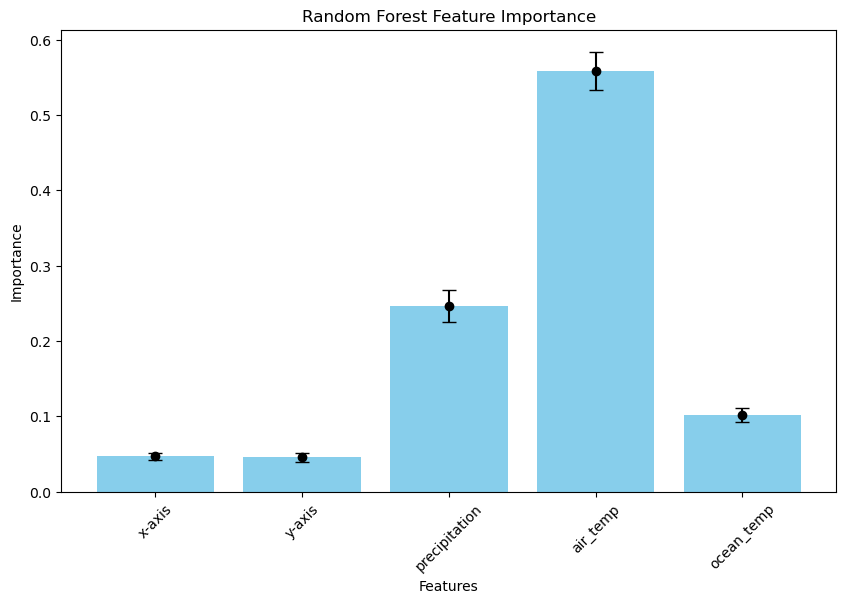

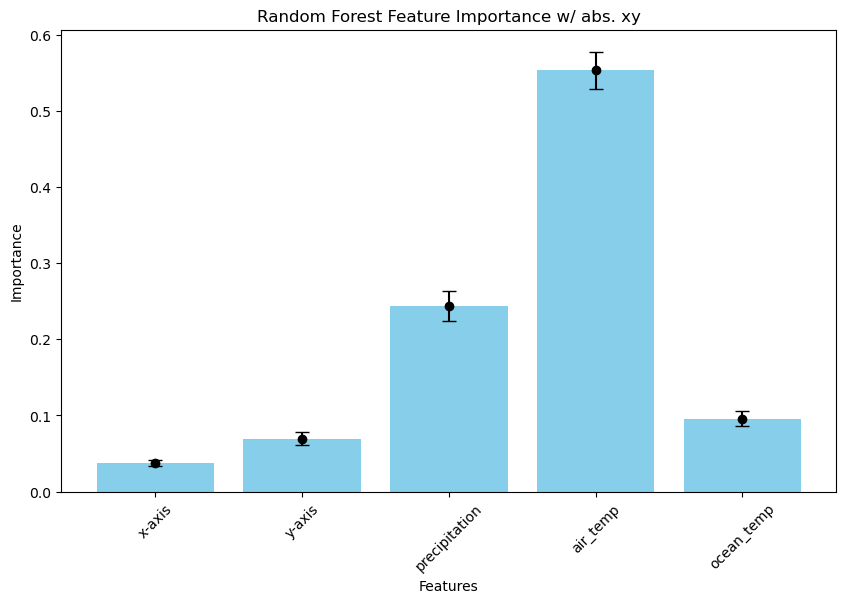

In [59]:
#++++++++++++++++++++++++++++++++++++++++++++RANDOM FOREST PLOTS++++++++++++++++++++++++++++++++++++++++++++
plot_importance(rf_importances_df,std_importances, "Random Forest Feature Importance")
plot_importance(abs_rf_importances_df, abs_std_importances, "Random Forest Feature Importance w/ abs. xy")


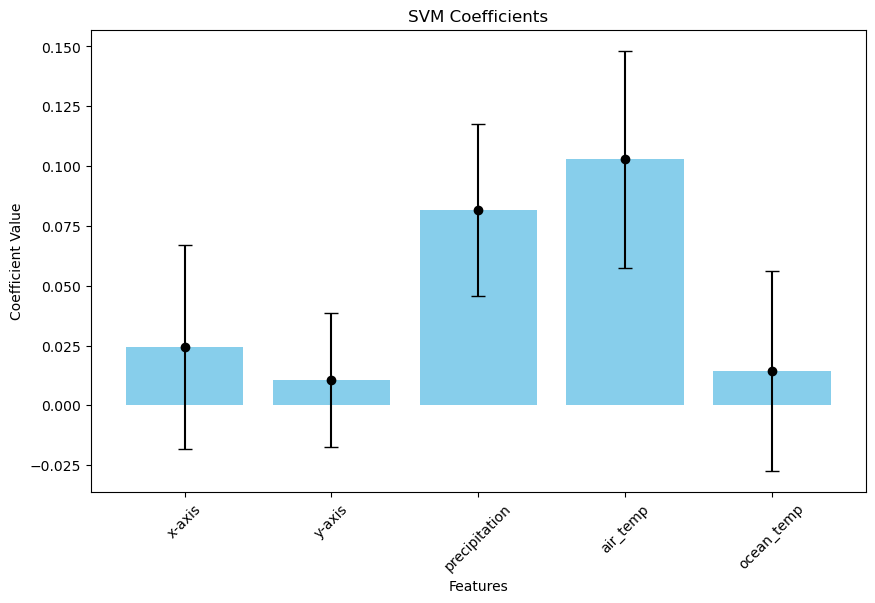

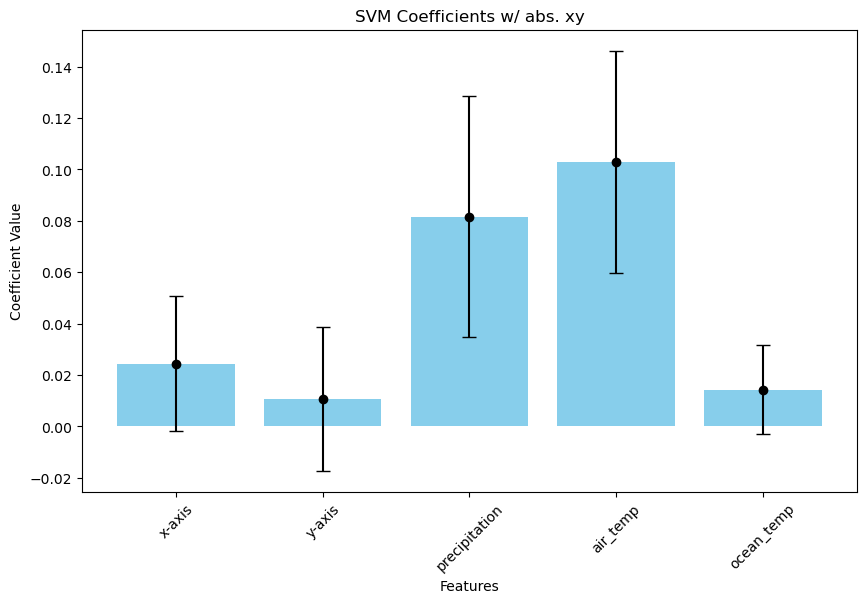

In [63]:
#++++++++++++++++++++++++++++++++++++++++++++SVM PLOTS++++++++++++++++++++++++++++++++++++++++++++
plot_coefficients(svm_coefficients_df, std_coefficients, "SVM Coefficients")
plot_coefficients(svm_coefficients_df, abs_std_coefficients, "SVM Coefficients w/ abs. xy")


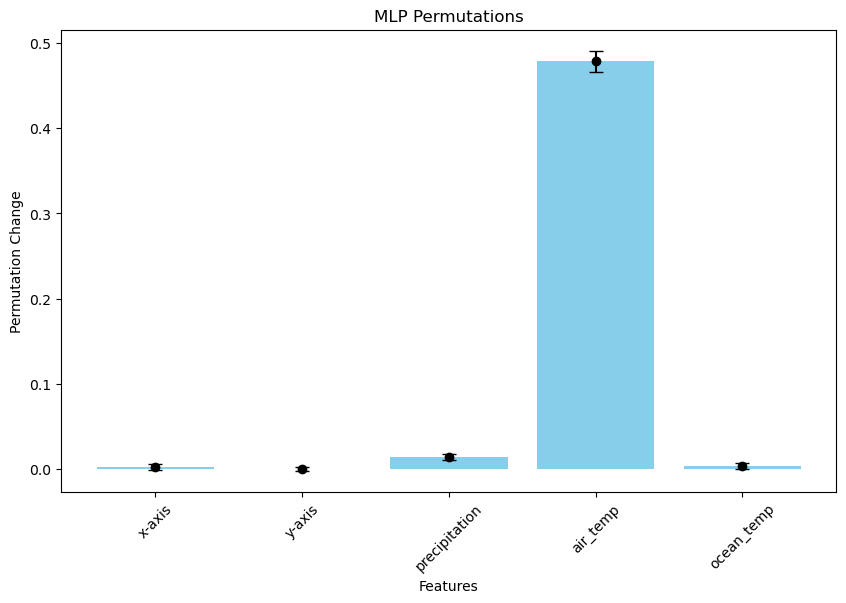

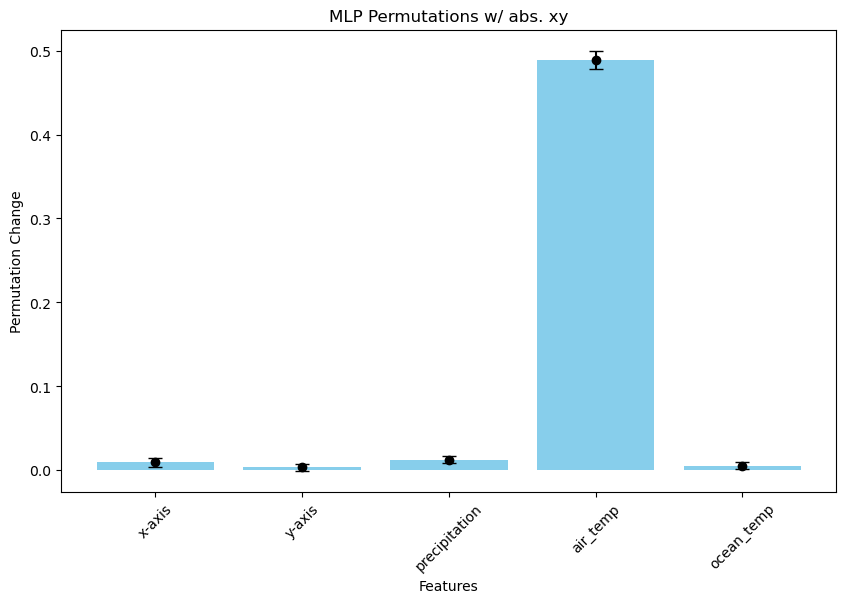

In [64]:
#++++++++++++++++++++++++++++++++++++++++++++MLP PLOTS++++++++++++++++++++++++++++++++++++++++++++
plot_permutations(mlp_perms_df, std_perms, "MLP Permutations")
plot_permutations(abs_mlp_perms_df, abs_std_perms, "MLP Permutations w/ abs. xy")
